Join quality: matched 38 / 38 districts (100.0%). Using lk='district_id' rk='district'.
Saved figure to: /home/aimlexpert/Documents/GitHub/texas-gerrymandering-HB4/images/racial_maps.png


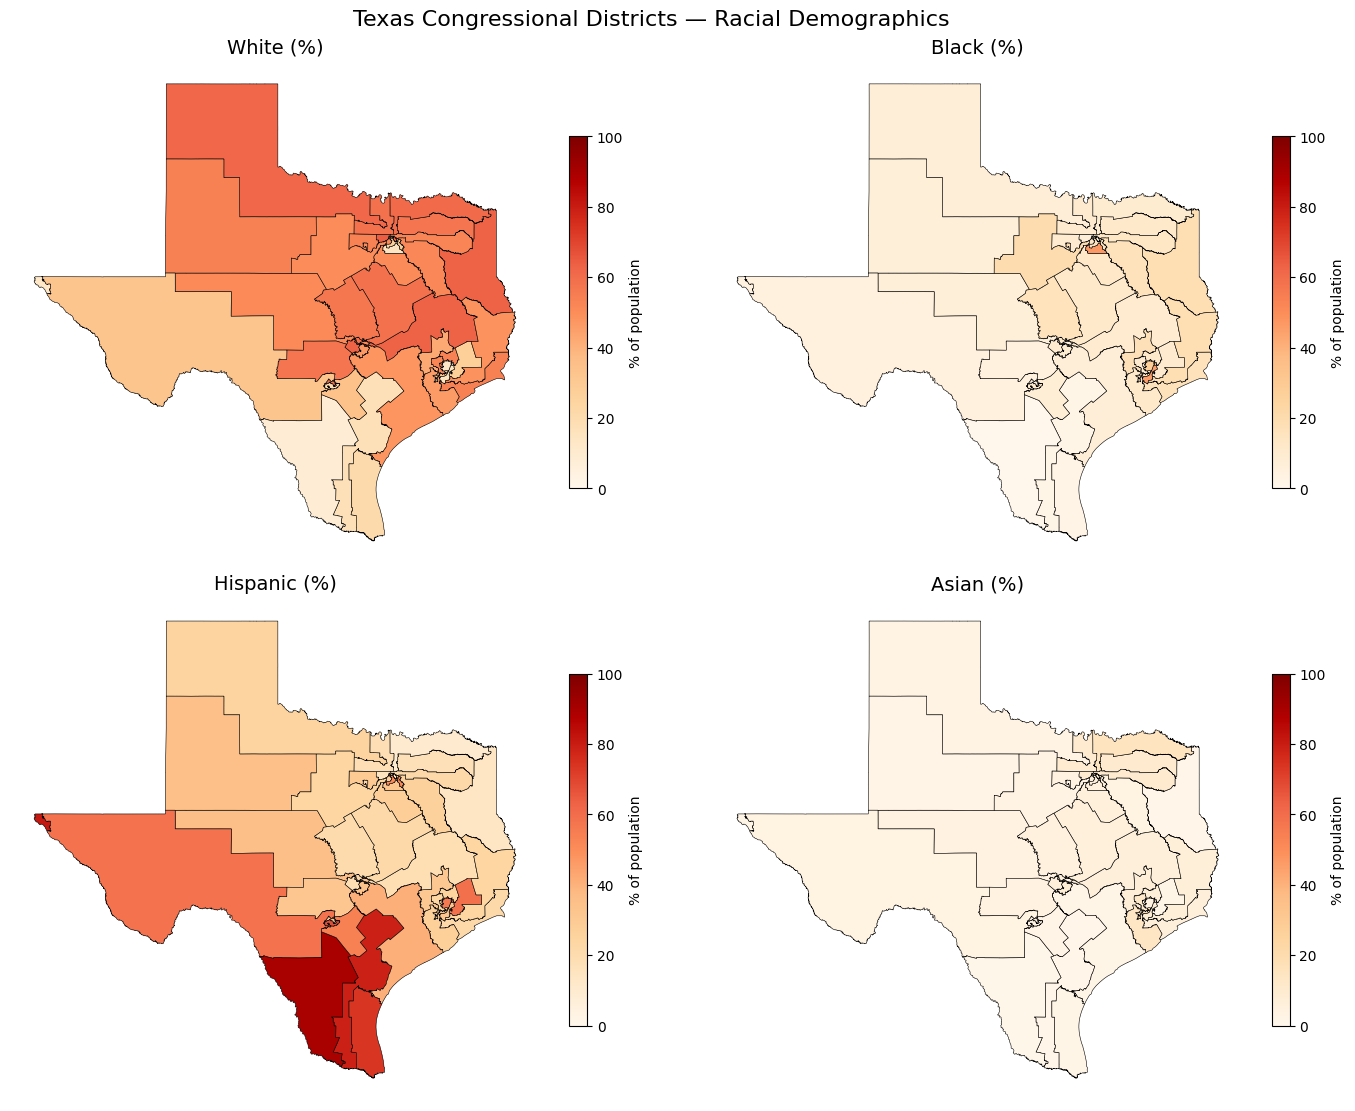

In [2]:

# --- Texas Districts: Racial Demographics Maps (robust & validated) ---
# Works with GeoPackage (.gpkg) or GeoParquet (.parquet) for districts geometry
# and CSV/Parquet for tabular attributes. Produces small multiples PNG.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path
import warnings

from texas_gerrymandering_hb4.config import FINAL_CSV, CLEAN_DISTRICTS_PARQUET, IMAGES_DIR

# ---------- CONFIG ----------
# Paths (edit if your repo uses different locations)


# Candidate join keys — we'll auto-detect the first pair that matches well
TABULAR_KEYS = ["district_id","District","district","DISTRICT","cd","CD","geoid","GEOID","GEOID10","GEOID20"]
GEO_KEYS     = ["district_id","District","district","DISTRICT","cd","CD","geoid","GEOID","GEOID10","GEOID20"]

# Candidate race columns — set explicitly if you know them
RACE_COLS = {
    "White (%)":   ["white_pct","white_share","pct_white","White_pct","WHITE_PCT"],
    "Black (%)":   ["black_pct","black_share","pct_black","Black_pct","BLACK_PCT"],
    "Hispanic (%)":["hispanic_pct","hisp_share","pct_hispanic","Hispanic_pct","HISP_PCT","latino_pct","pct_latino"],
    "Asian (%)":   ["asian_pct","asian_share","pct_asian","Asian_pct","ASIAN_PCT"],
}

# 0-1 or 0-100? If None, we'll auto-detect by looking at max value
VALUE_SCALE = None  # choose from {None, "0-1", "0-100"}

# ---------- HELPERS ----------
def read_geo(path: Path) -> gpd.GeoDataFrame:
    if path.suffix.lower() == ".gpkg":
        return gpd.read_file(path)
    elif path.suffix.lower() == ".parquet":
        return gpd.read_parquet(path)
    else:
        raise ValueError(f"Unsupported geometry format: {path}")

def coerce_district_id(s: pd.Series) -> pd.Series:
    """Try to coerce a wide variety of id formats into simple 1..38 integers for joining.
       Examples handled: '01', '1', 'TX-01', 'CD01', 'District 1', '4801' (will keep 1..2 digits at end)."""
    if s.dtype.kind in "biu":
        return s.astype("Int64")
    s = s.astype(str).str.strip()
    # pick trailing 1–2 digit number if it looks like a congressional district id (1..38)
    num = s.str.extract(r"(\d{1,2})$", expand=False)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        num = pd.to_numeric(num, errors="coerce")
    # If above failed everywhere, try exact numeric cast
    if num.notna().sum() == 0:
        num = pd.to_numeric(s, errors="coerce")
    return num.astype("Int64")

def find_join_key(left: pd.DataFrame, right: pd.DataFrame):
    for lk in TABULAR_KEYS:
        if lk not in left.columns:
            continue
        left_id = coerce_district_id(left[lk])
        if left_id.notna().sum() == 0:
            continue
        for rk in GEO_KEYS:
            if rk not in right.columns:
                continue
            right_id = coerce_district_id(right[rk])
            if right_id.notna().sum() == 0:
                continue
            overlap = pd.Series(left_id.dropna().unique()).isin(right_id.dropna().unique()).mean()
            if overlap > 0.8:  # good enough
                return lk, rk, left_id, right_id
    raise KeyError("Could not auto-detect a matching join key. Please set TABULAR_KEYS/GEO_KEYS correctly.")

def pick_first_existing(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def detect_value_scale(series: pd.Series):
    # decide if values look like 0-1 or 0-100
    x = series.dropna().astype(float)
    if x.empty:
        return "0-100"  # safe default for legend
    m = x.max()
    if m <= 1.0 + 1e-6:
        return "0-1"
    return "0-100"

def ensure_numeric(df, col):
    df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

# ---------- LOAD ----------
tab_path = FINAL_CSV
if not tab_path.exists():
    # also allow parquet for convenience
    alt = tab_path.with_suffix(".parquet")
    if alt.exists():
        tab_path = alt
    else:
        raise FileNotFoundError(f"Tabular file not found: {FINAL_CSV} or {alt}")

if tab_path.suffix.lower() == ".csv":
    tab = pd.read_csv(tab_path)
else:
    tab = pd.read_parquet(tab_path)

geo = read_geo(CLEAN_DISTRICTS_PARQUET)

# ---------- JOIN ----------
lk, rk, left_id, right_id = find_join_key(tab, geo)
tab = tab.assign(_DIST_ID=left_id)
geo = geo.assign(_DIST_ID=right_id)

# Keep only rows with valid ids
tab = tab[tab._DIST_ID.notna()].copy()
geo = geo[geo._DIST_ID.notna()].copy()

# Build a lean frame for joining
keep_cols = ["_DIST_ID"]
label_map = {}  # name -> column

for label, candidates in RACE_COLS.items():
    c = pick_first_existing(tab, candidates)
    if c is None:
        warnings.warn(f"Missing expected column for {label} (tried {candidates}). It will be omitted.")
        continue
    keep_cols.append(c)
    label_map[label] = c

attr = tab[keep_cols].copy()

# Convert to percentages consistently
scale = VALUE_SCALE or detect_value_scale(pd.concat([attr[c] for c in label_map.values()], axis=0))
for c in label_map.values():
    attr = ensure_numeric(attr, c)
    if scale == "0-1":
        attr[c] = attr[c] * 100.0
    # if already 0-100, keep as-is

merged = geo.merge(attr, on="_DIST_ID", how="left", validate="m:1")

# Validate join quality
total = len(geo)
matched = merged[label_map[next(iter(label_map))]].notna().sum() if label_map else 0
print(f"Join quality: matched {matched} / {total} districts ({matched/total:.1%}). Using lk='{lk}' rk='{rk}'.")

if matched/total < 0.8:
    warnings.warn("Low join rate (<80%). Your IDs may not align. Inspect '_DIST_ID', source columns, and formats.")

# ---------- PLOTTING ----------
labels_in_order = list(label_map.keys())
n = len(labels_in_order)
if n == 0:
    raise ValueError("No race columns found. Update RACE_COLS to match your dataset.")

# common color scale across panels
vmin = 0.0
vmax = 100.0

# Make small multiples
cols = 2
rows = int(np.ceil(n/cols))

fig, axes = plt.subplots(rows, cols, figsize=(14, 11), constrained_layout=True)
axes = np.atleast_2d(axes)

for i, label in enumerate(labels_in_order):
    r = i // cols; c = i % cols
    ax = axes[r, c]
    col = label_map[label]
    merged.plot(
        column=col,
        ax=ax,
        cmap="OrRd",
        vmin=vmin,
        vmax=vmax,
        legend=True,
        legend_kwds={"label": "% of population", "shrink": 0.7},
        edgecolor="black",
        linewidth=0.4,
        missing_kwds={"color": "#f0f0f0", "hatch": "///", "label": "No data"},
    )
    ax.set_axis_off()
    ax.set_title(label, fontsize=14, pad=6)

# Hide any empty subplots
for j in range(i+1, rows*cols):
    r = j // cols; c = j % cols
    axes[r, c].set_visible(False)

fig.suptitle("Texas Congressional Districts — Racial Demographics", fontsize=16)
plt.savefig(IMAGES_DIR, dpi=220, bbox_inches="tight")
print("Saved figure to:", IMAGES_DIR/"racial_maps.png")

# Also write a quick CSV integrity check next to the figure for debugging
#merged[["_DIST_ID"] + list(label_map.values())].to_csv(/_race_map_debug.csv", index=False)
#print("Wrote merge debug file to /mnt/data/_race_map_debug.csv")